In [1]:
import sys
sys.path.append("../../")

In [2]:
#from aix360.datasets.fashion_mnist_dataset import FMnistDataset
from aix360.datasets.dspirites_dataset import DSpiritesDataset
from aix360.algorithms.dipvae import DIPVAEExplainer

import torch
import numpy as np
import argparse

import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.
/home/bhanu/anaconda3/envs/aix360/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/bhanu/anaconda3/envs/aix360/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/bhanu/anaconda3/envs/aix360/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/bhanu/anaconda3/e

In [3]:
#dataset_obj = FMnistDataset()
dataset_obj = DSpiritesDataset()

torch.Size([737280, 64, 64])


In [4]:
cuda_available = torch.cuda.is_available()
print("CUDA: {}".format(cuda_available))

CUDA: False


In [5]:
dipvaeii_args = argparse.Namespace()

dipvaeii_args.model = 'dipvae-ii'

dipvaeii_args.activation_type = 'relu'
dipvaeii_args.num_nodes =  1200
dipvaeii_args.latent_dim = 10
dipvaeii_args.num_gen_layers = 3
dipvaeii_args.num_inference_layers = 2

dipvaeii_args.step_size = 0.001
dipvaeii_args.num_epochs = 5
dipvaeii_args.lambda_diag_factor = 10.0
dipvaeii_args.lambda_offdiag = 0.001

dipvaeii_args.seed = 0

In [6]:
dipvaeii_explainer = DIPVAEExplainer(model_args=dipvaeii_args, dataset=dataset_obj, cuda_available=cuda_available)

In [ ]:
dipvaeii_explainer.fit()

In [ ]:
%matplotlib inline

In [ ]:
def convert_and_reshape(x):
    return x.cpu().data.numpy().reshape([-1] + dataset_obj.data_dims)

def plot_reconstructions(dataset_obj, trained_net, input_images, image_id_to_plot=0):
        
    z_sample, _, _ = trained_net.encode(input_images)
    print(z_sample[image_id_to_plot])
    recons = trained_net.decode(z_sample)
    
    input_images_numpy = convert_and_reshape(input_images)
    recons_numpy = convert_and_reshape(recons)
    
    f, axarr = plt.subplots(1, 2)
    axarr[0].imshow(input_images_numpy[image_id_to_plot,:,:,0], cmap="gray")
    axarr[1].imshow(recons_numpy[image_id_to_plot,:,:,0], cmap="gray")

In [ ]:
for x, _ in dataset_obj.next_test_batch():
        input_images = x.squeeze().view(-1, np.prod(dataset_obj.data_dims))
        break

plot_reconstructions(dataset_obj, dipvaeii_explainer.net, input_images, image_id_to_plot=1)

In [ ]:
def plot_latent_traversal(explainer, input_images, args, image_id_to_plot=0, num_sweeps=15, max_abs_edit_value=10.0):
    edit_dim_values = np.linspace(-1.0 *max_abs_edit_value, max_abs_edit_value, num_sweeps)

    f, axarr = plt.subplots(args.latent_dim, len(edit_dim_values), sharex=True, sharey=True)
    f.set_size_inches(10, 10* args.latent_dim / len(edit_dim_values))

    for j in range(len(edit_dim_values)):
        for i in range(args.latent_dim):
            edited_images = convert_and_reshape(explainer.explain(input_images=input_images,
                             edit_dim_id = i,
                             edit_dim_value = edit_dim_values[j],edit_z_sample=True))
            axarr[i][j].imshow(edited_images[image_id_to_plot,:,:,0], cmap="gray", aspect='auto')
            #axarr[j][i].axis('off')
            if i == len(axarr) - 1:
                axarr[i][j].set_xlabel("z:" + str(np.round(edit_dim_values[j], 1)))
            if j == 0:
                axarr[i][j].set_ylabel("l:" + str(i))
            axarr[i][j].set_yticks([])
            axarr[i][j].set_xticks([])
    plt.subplots_adjust(hspace=0, wspace=0)

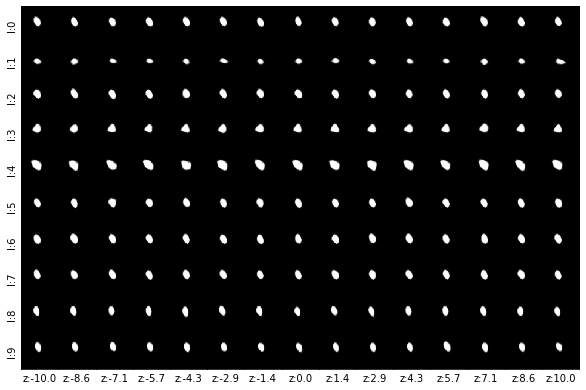

In [13]:
plot_latent_traversal(dipvaeii_explainer, input_images, dipvaeii_args, image_id_to_plot=1)